In [2]:

import zipfile


In [22]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import LabelEncoder

## Import Data

In [1]:
! wget -P ../../data/raw https://aqua.kingcounty.gov/extranet/assessor/Real%20Property%20Sales.zip
! wget -P ../../data/raw https://aqua.kingcounty.gov/extranet/assessor/Residential%20Building.zip

/bin/sh: wget: command not found
/bin/sh: wget: command not found


In [1]:
! which wget


wget not found


In [3]:
with zipfile.ZipFile('../../data/raw/Parcel.zip', 'r') as zip_ref:
    zip_ref.extractall('../../data/raw')
with zipfile.ZipFile('../../data/raw/Real Property Sales.zip', 'r') as zip_ref:
    zip_ref.extractall('../../data/raw')
with zipfile.ZipFile('../../data/raw/Residential Building.zip', 'r') as zip_ref:
    zip_ref.extractall('../../data/raw')

NameError: name 'zipfile' is not defined

In [30]:
parcel = pd.read_csv("../../data/raw/EXTR_Parcel.csv", encoding='latin-1')
real_property_sales = pd.read_csv("../../data/raw/EXTR_RPSale.csv", encoding='latin-1', low_memory=False)
residential_building = pd.read_csv("../../data/raw/EXTR_ResBldg.csv", encoding='latin-1', low_memory=False)

In [191]:
residential_building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517783 entries, 0 to 517782
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   Major              517783 non-null  int64
 1   Minor              517783 non-null  int64
 2   NbrLivingUnits     517783 non-null  int64
 3   SqFtTotLiving      517783 non-null  int64
 4   SqFtOpenPorch      517783 non-null  int64
 5   SqFtEnclosedPorch  517783 non-null  int64
 6   Has_Porch          517783 non-null  int64
dtypes: int64(7)
memory usage: 27.7 MB


## Clean Data and Filter For Needed Info

In [31]:
# Real Property Sales
# Identifyers are Major and Minor. Relevant data is SalePrice
# Clean real_property_sales to have proper values in Minor and Major and change type to int to match other data sets
real_property_sales = real_property_sales[['Major', 'Minor', 'SalePrice', 'DocumentDate']]
real_property_sales = real_property_sales[(real_property_sales['Major'].str.isdecimal()==True) &
                                          (real_property_sales['Minor'].str.isdecimal()==True)]
real_property_sales['Major'] = real_property_sales['Major'].astype('int64')
real_property_sales['Minor'] = real_property_sales['Minor'].astype('int64')
real_property_sales = real_property_sales[real_property_sales['SalePrice']>0]

In [32]:
real_property_sales.head()

,Major,Minor,SalePrice,DocumentDate
0,138860,110,245000,08/21/2014
4,213043,120,560000,12/20/2019
5,951120,900,85000,04/20/1989
7,122209,9002,5755000,04/25/2001
8,122209,9001,5755000,04/25/2001


In [33]:
# Parcel Filter for Necessary Columns
parcel = parcel[['Major', 'Minor', 'SqFtLot', 'WfntLocation', 'TrafficNoise', 'AirportNoise', 'PowerLines', 'OtherNuisances']]
parcel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616089 entries, 0 to 616088
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Major           616089 non-null  int64 
 1   Minor           616089 non-null  int64 
 2   SqFtLot         616089 non-null  int64 
 3   WfntLocation    616089 non-null  int64 
 4   TrafficNoise    616089 non-null  int64 
 5   AirportNoise    616089 non-null  int64 
 6   PowerLines      616089 non-null  object
 7   OtherNuisances  616089 non-null  object
dtypes: int64(6), object(2)
memory usage: 37.6+ MB


In [34]:
# Residential Buiding Filter For Necessary Columns
residential_building = residential_building[['Major', 'Minor', 'NbrLivingUnits', 'SqFtTotLiving', 'SqFtOpenPorch', 'SqFtEnclosedPorch']]

In [35]:
# Create a column Has_Porch
residential_building['Has_Porch']= residential_building['SqFtOpenPorch'] + residential_building['SqFtEnclosedPorch']
residential_building['Has_Porch'] = [1  if p>0 else 0 for p in residential_building['Has_Porch']]

In [36]:
residential_building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517783 entries, 0 to 517782
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   Major              517783 non-null  int64
 1   Minor              517783 non-null  int64
 2   NbrLivingUnits     517783 non-null  int64
 3   SqFtTotLiving      517783 non-null  int64
 4   SqFtOpenPorch      517783 non-null  int64
 5   SqFtEnclosedPorch  517783 non-null  int64
 6   Has_Porch          517783 non-null  int64
dtypes: int64(7)
memory usage: 27.7 MB


In [37]:
# Join all the tables on Major, Minor
# Have duplicate buildings sold at different dates. Need to only keep latest dates
merged_tables = real_property_sales.merge(parcel).merge(residential_building).drop_duplicates()
# Change dates to date time format
merged_tables['DocumentDate'] = pd.to_datetime(merged_tables['DocumentDate'])

In [38]:
#Keeping only the most recent Sale_Price
buildings_df = merged_tables.sort_values('DocumentDate').drop_duplicates(['Major', 'Minor'],keep='first')

In [39]:
df_test = buildings_df.sort_values('DocumentDate')
df_test

,Major,Minor,SalePrice,DocumentDate,SqFtLot,WfntLocation,TrafficNoise,AirportNoise,PowerLines,OtherNuisances,NbrLivingUnits,SqFtTotLiving,SqFtOpenPorch,SqFtEnclosedPorch,Has_Porch
705940,514510,250,125000,1934-11-11,7041,0,0,0,N,N,1,910,0,0,0
443490,718680,30,600,1954-03-11,9345,0,0,0,N,N,1,1380,40,0,1
653999,245840,30,9500,1955-04-15,6300,0,1,0,N,N,1,820,0,0,0
962419,222470,151,12250,1959-10-10,11115,0,1,0,N,N,1,2090,0,0,0
235295,503180,251,2300,1960-09-27,19064,3,0,0,N,N,1,1140,40,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900477,241990,45,642000,2020-09-08,11054,0,0,0,N,N,1,1510,0,0,0
366504,327530,150,393000,2020-09-09,9500,0,0,0,N,N,1,1250,110,0,1
925600,797260,2865,590000,2020-09-09,10275,0,0,0,N,N,1,1660,40,0,1
960304,330070,280,535000,2020-09-09,4000,0,0,0,N,N,1,700,0,0,0


In [77]:
# Check x if have the relevant data to answer question
# [x]Higher square footage increases home sale price1, 2
# [x]Having a porch increases home sale price3, 4
# [x]Having a beachfront or lakefront increases home sale price5
# [x]The house filling a higher proportion of the overall lot decreases home sale price6
# [x]The cost per square foot is lower in duplexes than in single-family homes7
# [x]The presence of a nuisance (power lines, traffic noise, airport noise) decreases home sale price1, 5

## Graphical EDA

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

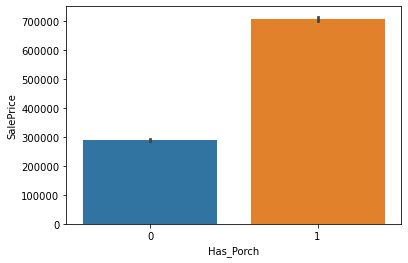

In [14]:
sns.barplot(df['Has_Porch'], df['SalePrice']);




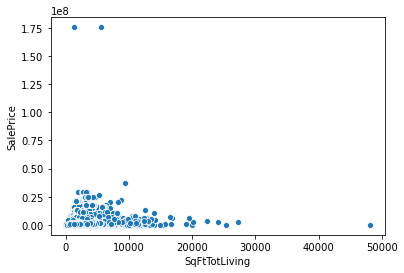

In [15]:
sns.scatterplot(df['SqFtTotLiving'], df['SalePrice']);




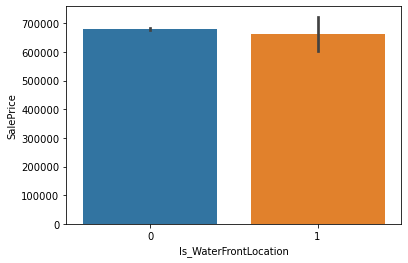

In [64]:
sns.barplot(df['Is_WaterFrontLocation'], df['SalePrice']);

In [378]:
df = pd.read_csv('../../data/clean/KingCountyHousingData.csv')
df.head()


,Unnamed: 0,Major,Minor,ZipCode,DocumentDate,SalePrice,SqFtLot,SqFtTotLiving,Nuisances,Has_Nuisance,...,Has_EnclosedPorch,NbrLivingUnits,View_MtRainier,View_Olympics,View_Cascades,View_PugetSound,View_LakeWashington,View_LakeSammamish,View_SmallLakeRiverCreek,BldgGrade
0,0,100,67,98002,2019-04-01,310800,17400,2240,No Nuisances,0,...,0,1,0,0,0,0,0,0,0,6
1,1,100,66,98002,2019-10-22,339000,14500,1200,No Nuisances,0,...,0,1,0,0,0,0,0,0,0,5
2,2,100,42,98002,2019-10-29,485500,6002,2134,No Nuisances,0,...,0,1,0,0,0,0,0,0,0,5
3,3,120,8,98166,2019-05-17,850000,24142,3500,No Nuisances,0,...,0,1,0,0,0,0,0,0,0,6
4,4,140,27,98178,2019-05-28,535000,14208,2170,Traffic Noise,1,...,0,1,0,0,0,0,0,0,0,5


In [207]:
#df.hist(figsize=(18,15), bins='auto');

In [379]:
df_water_dummie =pd.get_dummies(df['WaterFrontLocation'])
df_water_dummie.drop('None', axis= 1, inplace=True)
#df_water_dummie['SqFtTotLiving'] = df.SqFtTotLiving
df_water_dummie


,Duwamish,Lake Sammamish,Lake Union,Lake Washington,Other lake,Puget Sound,River or slough,Ship Canal
0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
27809,0,0,0,0,0,0,0,0
27810,0,0,0,0,0,0,0,0
27811,0,0,0,0,0,0,0,0
27812,0,0,0,0,0,0,0,0


In [209]:
from sklearn.linear_model import LinearRegression



In [210]:
lr = LinearRegression()
lr.fit(df_water_dummie, df['SalePrice'])
#lr.__dict__


LinearRegression()

In [211]:
lr.score(df_water_dummie, df['SalePrice'])



0.39382491267103936

In [212]:
lr.coef_



array([-8.64230198e+03,  1.82451159e+06,  3.66917232e+05,  2.08094891e+06,
        3.48825330e+04,  4.17368854e+05,  4.61416527e+04,  8.82451221e+05,
        3.35148305e+02])

In [213]:
for col, coef in zip(list(df_water_dummie), lr.coef_):
    print(col,coef)


Duwamish -8642.301984721033
Lake Sammamish 1824511.5948370975
Lake Union 366917.232058954
Lake Washington 2080948.9118916402
Other lake 34882.53301025234
Puget Sound 417368.85403985356
River or slough 46141.652652212695
Ship Canal 882451.2212115147
SqFtTotLiving 335.148304847272


## Concatinate the two data frames

In [380]:
comb_df = pd.concat([df, df_water_dummie], axis=1)
comb_df.head()

,Unnamed: 0,Major,Minor,ZipCode,DocumentDate,SalePrice,SqFtLot,SqFtTotLiving,Nuisances,Has_Nuisance,...,View_SmallLakeRiverCreek,BldgGrade,Duwamish,Lake Sammamish,Lake Union,Lake Washington,Other lake,Puget Sound,River or slough,Ship Canal
0,0,100,67,98002,2019-04-01,310800,17400,2240,No Nuisances,0,...,0,6,0,0,0,0,0,0,0,0
1,1,100,66,98002,2019-10-22,339000,14500,1200,No Nuisances,0,...,0,5,0,0,0,0,0,0,0,0
2,2,100,42,98002,2019-10-29,485500,6002,2134,No Nuisances,0,...,0,5,0,0,0,0,0,0,0,0
3,3,120,8,98166,2019-05-17,850000,24142,3500,No Nuisances,0,...,0,6,0,0,0,0,0,0,0,0
4,4,140,27,98178,2019-05-28,535000,14208,2170,Traffic Noise,1,...,0,5,0,0,0,0,0,0,0,0


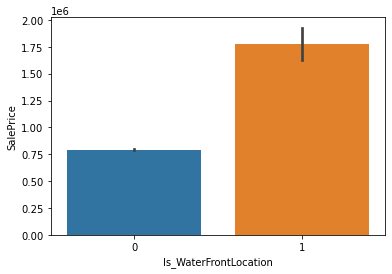

In [229]:
sns.barplot(df['Is_WaterFrontLocation'], df['SalePrice']);



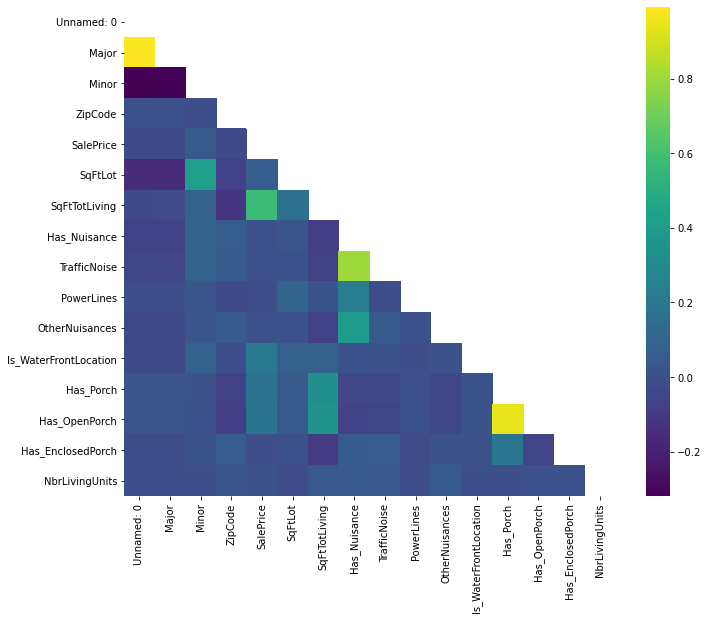

In [215]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig1, ax1 = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, ax=ax1, cmap="viridis");



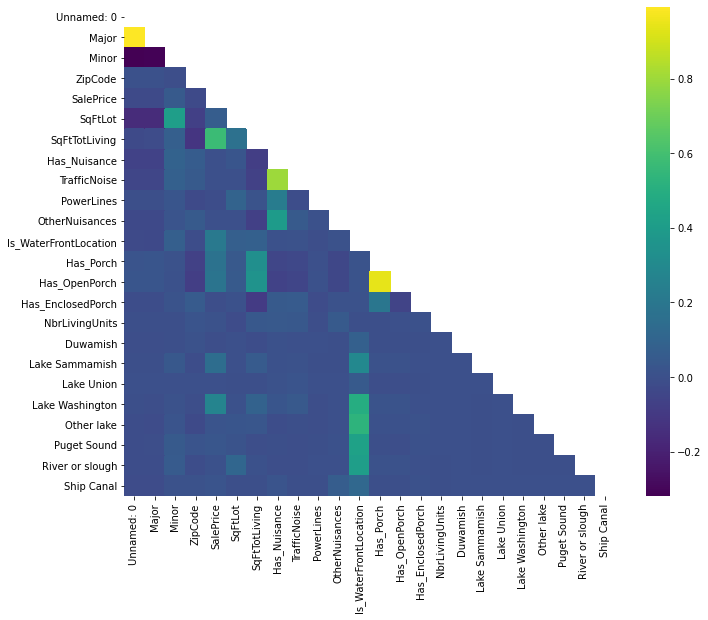

In [233]:
corr = comb_df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig1, ax1 = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, ax=ax1, cmap="viridis");

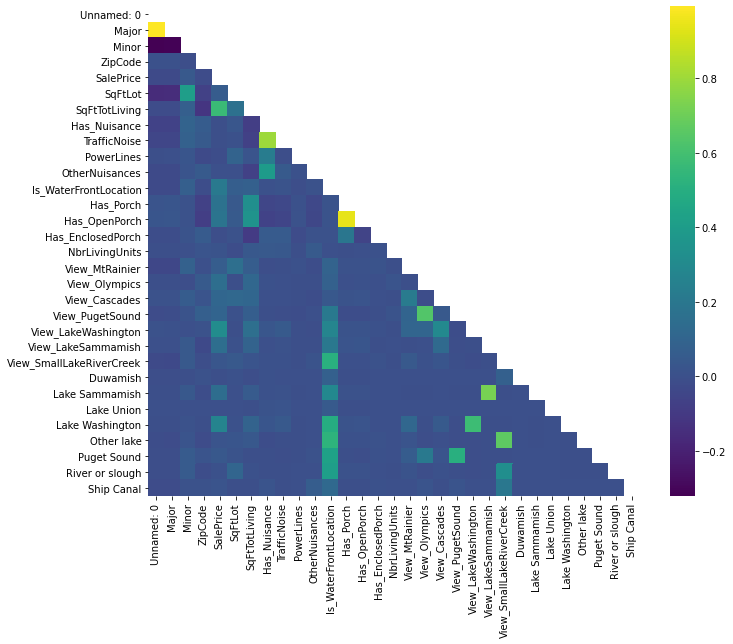

In [348]:
corr = comb_df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig1, ax1 = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, ax=ax1, cmap="viridis");

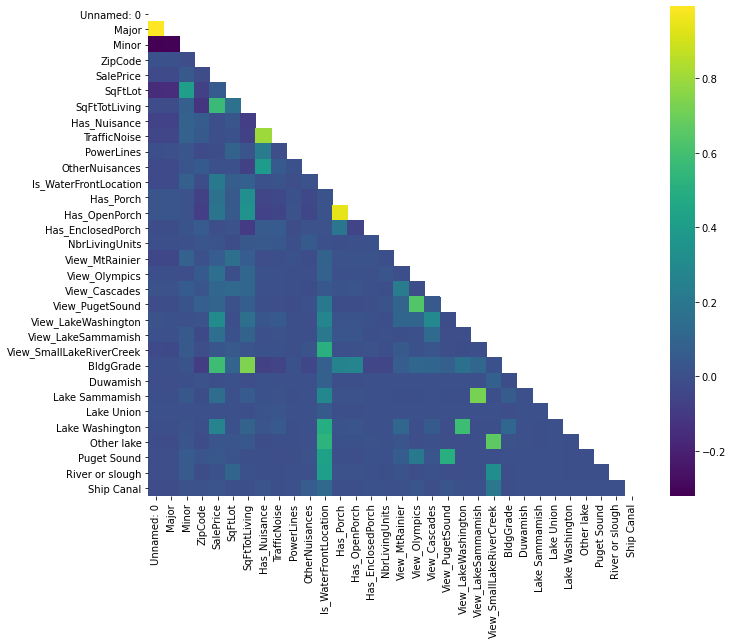

In [381]:
corr = comb_df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig1, ax1 = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, ax=ax1, cmap="viridis");

## EDA simple models


In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
%matplotlib inline

### FSM_Model 1

In [113]:
outcome = 'SalePrice'
x_cols = ['SqFtTotLiving']

In [115]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
fsm_model = ols(formula=formula, data=df).fit()
fsm_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                 1.603e+04
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        13:04:10   Log-Likelihood:            -4.1190e+05
No. Observations:               28824   AIC:                         8.238e+05
Df Residuals:                   28822   BIC:                         8.238e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.106e+05   5757.098     19.217      0.000    9.93e+04    1.22e+05
SqFtTotLiving   306.1794      2.419    126.597      0.000     301.439     310.920
==============================================================================
Omnibus:                    13104.282   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           110455.449
Skew:                           1.996   Prob(JB):                         0.00
Kurtosis:                      11.720   Cond. No.                     5.98e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.98e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### FSM_Model 2

In [111]:
outcome = 'SalePrice'
x_cols = ['Has_Porch']

In [112]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
fsm_model = ols(formula=formula, data=df).fit()
fsm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     1287.
Date:                Tue, 29 Sep 2020   Prob (F-statistic):          9.26e-276
Time:                        13:01:19   Log-Likelihood:            -4.1765e+05
No. Observations:               28824   AIC:                         8.353e+05
Df Residuals:                   28822   BIC:                         8.353e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.667e+05   4202.924    158.627      0.000    6.58e+05    6.75e+05
Has_Porch    2.02e+05   5630.090     35.873      0.000    1.91e+05    2.13e+05
==============================================================================
Omnibus:                    13917.537   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            91641.326
Skew:                           2.256   Prob(JB):                         0.00
Kurtosis:                      10.480   Cond. No.                         2.77
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### FSM_Model 3

In [116]:
outcome = 'SalePrice'
x_cols = ['Is_WaterFrontLocation']


In [117]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
fsm_model = ols(formula=formula, data=df).fit()
fsm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     543.6
Date:                Tue, 29 Sep 2020   Prob (F-statistic):          3.96e-119
Time:                        13:06:08   Log-Likelihood:            -4.1801e+05
No. Observations:               28824   AIC:                         8.360e+05
Df Residuals:                   28822   BIC:                         8.360e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              7.713e+05   2852.292    270.404      0.000    7.66e+05    7.77e+05
Is_WaterFrontLocation  5.542e+05   2.38e+04     23.315      0.000    5.08e+05    6.01e+05
==============================================================================
Omnibus:                    13630.220   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            85827.233
Skew:                           2.217   Prob(JB):                         0.00
Kurtosis:                      10.198   Cond. No.                         8.40
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### FSM_Model 4

In [120]:
outcome = 'SalePrice'
x_cols = ['Has_Nuisance']

In [121]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
fsm_model = ols(formula=formula, data=df).fit()
fsm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.043
Date:                Tue, 29 Sep 2020   Prob (F-statistic):              0.307
Time:                        13:09:15   Log-Likelihood:            -4.1827e+05
No. Observations:               28824   AIC:                         8.366e+05
Df Residuals:                   28822   BIC:                         8.366e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     7.779e+05   3137.880    247.915      0.000    7.72e+05    7.84e+05
Has_Nuisance  7765.3750   7603.559      1.021      0.307   -7137.952    2.27e+04
==============================================================================
Omnibus:                    14136.291   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            92644.887
Skew:                           2.303   Prob(JB):                         0.00
Kurtosis:                      10.478   Cond. No.                         2.75
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### FSM_Model 5

In [124]:
outcome = 'SalePrice'
x_cols = ['SqFtLot']

In [125]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
fsm_model = ols(formula=formula, data=df).fit()
fsm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     147.2
Date:                Tue, 29 Sep 2020   Prob (F-statistic):           8.65e-34
Time:                        13:12:40   Log-Likelihood:            -4.1820e+05
No. Observations:               28824   AIC:                         8.364e+05
Df Residuals:                   28822   BIC:                         8.364e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7.606e+05   3239.580    234.779      0.000    7.54e+05    7.67e+05
SqFtLot        1.4735      0.121     12.132      0.000       1.235       1.712
==============================================================================
Omnibus:                    14076.440   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            92185.738
Skew:                           2.291   Prob(JB):                         0.00
Kurtosis:                      10.467   Cond. No.                     3.03e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.03e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Multilinear Models


### ML_Model 1

In [234]:
outcome = 'SalePrice'
x_cols = ['SqFtTotLiving','Has_Porch' ]


In [236]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
ml_model1 = ols(formula=formula, data=df).fit()
ml_model1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     6822.
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        19:42:35   Log-Likelihood:            -4.0289e+05
No. Observations:               27728   AIC:                         8.058e+05
Df Residuals:                   27725   BIC:                         8.058e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      3.764e+04   7373.289      5.105      0.000    2.32e+04    5.21e+04
SqFtTotLiving   353.4087      3.181    111.086      0.000     347.173     359.644
Has_Porch     -1.431e+04   6330.603     -2.261      0.024   -2.67e+04   -1904.546
==============================================================================
Omnibus:                    28674.977   Durbin-Watson:                   1.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3431705.698
Skew:                           4.954   Prob(JB):                         0.00
Kurtosis:                      56.592   Cond. No.                     6.19e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### ML_Model 2

In [141]:
outcome = 'SalePrice'
x_cols = ['SqFtTotLiving','Has_Porch', 'Is_WaterFrontLocation']


In [155]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
ml_model2 = ols(formula=formula, data=df).fit()
ml_model2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     5639.
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        13:38:21   Log-Likelihood:            -4.1162e+05
No. Observations:               28824   AIC:                         8.232e+05
Df Residuals:                   28820   BIC:                         8.233e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1.079e+05   5763.462     18.716      0.000    9.66e+04    1.19e+05
SqFtTotLiving           302.5124      2.543    118.947      0.000     297.528     307.497
Has_Porch              7563.4853   4847.244      1.560      0.119   -1937.338    1.71e+04
Is_WaterFrontLocation  4.555e+05   1.91e+04     23.894      0.000    4.18e+05    4.93e+05
==============================================================================
Omnibus:                    12545.159   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           102534.109
Skew:                           1.901   Prob(JB):                         0.00
Kurtosis:                      11.422   Cond. No.                     2.00e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  2e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [382]:
comb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27814 entries, 0 to 27813
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                27814 non-null  int64 
 1   Major                     27814 non-null  int64 
 2   Minor                     27814 non-null  int64 
 3   ZipCode                   27814 non-null  int64 
 4   DocumentDate              27814 non-null  object
 5   SalePrice                 27814 non-null  int64 
 6   SqFtLot                   27814 non-null  int64 
 7   SqFtTotLiving             27814 non-null  int64 
 8   Nuisances                 27814 non-null  object
 9   Has_Nuisance              27814 non-null  int64 
 10  TrafficNoise              27814 non-null  int64 
 11  PowerLines                27814 non-null  int64 
 12  OtherNuisances            27814 non-null  int64 
 13  Is_WaterFrontLocation     27814 non-null  int64 
 14  WaterFrontLocation    

In [383]:
comb_df = comb_df.rename(columns={"Other lake": "Other_lake","Lake Sammamish":"Lake_Sammamish", "Lake Union": "Lake_Union", "Lake Washington": "Lake_Washington", "Puget Sound": "Puget_Sound", "River or slough":"River_or_slough", "Ship Canal": "Ship_Canal" })

In [384]:
comb_df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27814 entries, 0 to 27813
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                27814 non-null  int64 
 1   Major                     27814 non-null  int64 
 2   Minor                     27814 non-null  int64 
 3   ZipCode                   27814 non-null  int64 
 4   DocumentDate              27814 non-null  object
 5   SalePrice                 27814 non-null  int64 
 6   SqFtLot                   27814 non-null  int64 
 7   SqFtTotLiving             27814 non-null  int64 
 8   Nuisances                 27814 non-null  object
 9   Has_Nuisance              27814 non-null  int64 
 10  TrafficNoise              27814 non-null  int64 
 11  PowerLines                27814 non-null  int64 
 12  OtherNuisances            27814 non-null  int64 
 13  Is_WaterFrontLocation     27814 non-null  int64 
 14  WaterFrontLocation    

### ML_Model 3 --water

In [326]:
outcome = 'SalePrice'
x_cols = ['SqFtTotLiving','Duwamish', 'Lake_Sammamish', 'Lake_Union', 'Lake_Union', 'Lake_Washington', 'Other_lake','Puget_Sound', 'River_or_slough', 'Ship_Canal']


In [327]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
ml_model3 = ols(formula=formula, data=comb_df).fit()
ml_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     2001.
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        20:36:02   Log-Likelihood:            -4.0150e+05
No. Observations:               27728   AIC:                         8.030e+05
Df Residuals:                   27718   BIC:                         8.031e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        5.663e+04   6932.048      8.169      0.000     4.3e+04    7.02e+04
SqFtTotLiving     335.1483      2.877    116.486      0.000     329.509     340.788
Duwamish        -8642.3020   2.72e+05     -0.032      0.975   -5.41e+05    5.24e+05
Lake_Sammamish   1.825e+06   7.36e+04     24.787      0.000    1.68e+06    1.97e+06
Lake_Union       3.669e+05    4.7e+05      0.780      0.435   -5.55e+05    1.29e+06
Lake_Washington  2.081e+06   4.39e+04     47.360      0.000    1.99e+06    2.17e+06
Other_lake       3.488e+04   4.09e+04      0.853      0.394   -4.53e+04    1.15e+05
Puget_Sound      4.174e+05   4.97e+04      8.405      0.000     3.2e+05    5.15e+05
River_or_slough  4.614e+04   5.27e+04      0.876      0.381   -5.71e+04    1.49e+05
Ship_Canal       8.825e+05   1.78e+05      4.964      0.000    5.34e+05    1.23e+06
==============================================================================
Omnibus:                    26453.788   Durbin-Watson:                   0.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3114673.024
Skew:                           4.295   Prob(JB):                         0.00
Kurtosis:                      54.206   Cond. No.                     4.03e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.03e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### ML_Model 4.2- Water and Mountain View

In [353]:
outcome = 'SalePrice'
x_cols = ['SqFtTotLiving','View_MtRainier', 'View_Olympics','View_Cascades', 'View_PugetSound', 'View_LakeWashington', 'View_LakeSammamish','View_SmallLakeRiverCreek']



In [354]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
ml_model3 = ols(formula=formula, data=comb_df).fit()
ml_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     2292.
Date:                Wed, 30 Sep 2020   Prob (F-statistic):               0.00
Time:                        09:33:20   Log-Likelihood:            -4.0269e+05
No. Observations:               27814   AIC:                         8.054e+05
Df Residuals:                   27805   BIC:                         8.055e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 7.258e+04   6933.643     10.468      0.000     5.9e+04    8.62e+04
SqFtTotLiving              318.5155      2.919    109.103      0.000     312.793     324.238
View_MtRainier            2.373e+04   1.16e+04      2.049      0.040    1032.015    4.64e+04
View_Olympics             5.577e+04   9524.956      5.855      0.000    3.71e+04    7.44e+04
View_Cascades            -5.706e+04   7570.536     -7.537      0.000   -7.19e+04   -4.22e+04
View_PugetSound           7.364e+04   9351.981      7.874      0.000    5.53e+04     9.2e+04
View_LakeWashington        3.69e+05   7669.740     48.116      0.000    3.54e+05    3.84e+05
View_LakeSammamish        3.232e+05   1.39e+04     23.176      0.000    2.96e+05    3.51e+05
View_SmallLakeRiverCreek  5.924e+04   1.05e+04      5.624      0.000    3.86e+04    7.99e+04
==============================================================================
Omnibus:                    27329.781   Durbin-Watson:                   1.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3312282.035
Skew:                           4.515   Prob(JB):                         0.00
Kurtosis:                      55.693   Cond. No.                     1.21e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.21e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## ML_Model4 -- Nuisance

In [328]:
outcome = 'SalePrice'
x_cols = ['SqFtTotLiving','TrafficNoise', 'PowerLines']


In [329]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
ml_model4 = ols(formula=formula, data=comb_df).fit()
ml_model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     4591.
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        20:36:51   Log-Likelihood:            -4.0285e+05
No. Observations:               27728   AIC:                         8.057e+05
Df Residuals:                   27724   BIC:                         8.057e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2.348e+04   7416.255      3.167      0.002    8948.641     3.8e+04
SqFtTotLiving   352.9423      3.008    117.320      0.000     347.046     358.839
TrafficNoise   4.314e+04   5353.512      8.059      0.000    3.27e+04    5.36e+04
PowerLines    -1.475e+05    2.9e+04     -5.094      0.000   -2.04e+05   -9.07e+04
==============================================================================
Omnibus:                    28736.048   Durbin-Watson:                   1.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3490612.831
Skew:                           4.967   Prob(JB):                         0.00
Kurtosis:                      57.061   Cond. No.                     2.36e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.36e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### ML_Model 5 --Porch 

In [330]:
outcome = 'SalePrice'
x_cols = ['SqFtTotLiving', 'Has_OpenPorch','Has_EnclosedPorch']


In [331]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
ml_model5 = ols(formula=formula, data=comb_df).fit()
ml_model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     4591.
Date:                Tue, 29 Sep 2020   Prob (F-statistic):               0.00
Time:                        20:37:05   Log-Likelihood:            -4.0285e+05
No. Observations:               27728   AIC:                         8.057e+05
Df Residuals:                   27724   BIC:                         8.057e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          2.793e+04   7419.216      3.765      0.000    1.34e+04    4.25e+04
SqFtTotLiving       358.2657      3.220    111.246      0.000     351.953     364.578
Has_OpenPorch     -2.734e+04   6359.046     -4.300      0.000   -3.98e+04   -1.49e+04
Has_EnclosedPorch  1.192e+05   1.41e+04      8.421      0.000    9.14e+04    1.47e+05
==============================================================================
Omnibus:                    28710.064   Durbin-Watson:                   1.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3466978.989
Skew:                           4.961   Prob(JB):                         0.00
Kurtosis:                      56.874   Cond. No.                     1.16e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### ML_Model 6 --Zip Code

In [405]:
outcome = 'SalePrice'
x_cols = ['SqFtTotLiving','ZipCode']

In [406]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
ml_model6 = ols(formula=formula, data=comb_df).fit()
ml_model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     6827.
Date:                Wed, 30 Sep 2020   Prob (F-statistic):               0.00
Time:                        10:54:32   Log-Likelihood:            -4.0418e+05
No. Observations:               27814   AIC:                         8.084e+05
Df Residuals:                   27811   BIC:                         8.084e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.679e+07   2.98e+06     -8.982      0.000   -3.26e+07   -2.09e+07
SqFtTotLiving   353.3749      3.026    116.766      0.000     347.443     359.307
ZipCode         273.3905     30.400      8.993      0.000     213.805     332.976
==============================================================================
Omnibus:                    28683.585   Durbin-Watson:                   1.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3418964.673
Skew:                           4.931   Prob(JB):                         0.00
Kurtosis:                      56.412   Cond. No.                     9.85e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.85e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### ML_Model 7 --All together

In [385]:
outcome = 'SalePrice'
x_cols = ['SqFtTotLiving','Duwamish', 'Lake_Sammamish', 'Lake_Union', 
          'Lake_Washington', 'Other_lake','Puget_Sound', 'River_or_slough', 'Ship_Canal',
         'TrafficNoise', 'PowerLines','Has_OpenPorch', 'Has_EnclosedPorch', 'ZipCode', 
          'View_MtRainier', 'View_Olympics','View_Cascades', 'View_PugetSound', 'View_LakeWashington',
          'View_LakeSammamish','View_SmallLakeRiverCreek', 'SqFtLot', 'NbrLivingUnits','BldgGrade']



In [386]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
ml_model7 = ols(formula=formula, data=comb_df).fit()
ml_model7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     990.0
Date:                Wed, 30 Sep 2020   Prob (F-statistic):               0.00
Time:                        10:49:02   Log-Likelihood:            -4.0114e+05
No. Observations:               27814   AIC:                         8.023e+05
Df Residuals:                   27789   BIC:                         8.025e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -2.044e+07    2.7e+06     -7.574      0.000   -2.57e+07   -1.52e+07
SqFtTotLiving              187.4640      4.242     44.193      0.000     179.150     195.778
Duwamish                 -3.716e+04   2.58e+05     -0.144      0.886   -5.44e+05    4.69e+05
Lake_Sammamish            1.478e+06   1.02e+05     14.491      0.000    1.28e+06    1.68e+06
Lake_Union                5.396e+05   4.44e+05      1.215      0.225   -3.31e+05    1.41e+06
Lake_Washington           1.227e+06   5.21e+04     23.541      0.000    1.13e+06    1.33e+06
Other_lake                -7.35e+04   5.62e+04     -1.307      0.191   -1.84e+05    3.67e+04
Puget_Sound               2.102e+05   5.54e+04      3.796      0.000    1.02e+05    3.19e+05
River_or_slough           1.684e+04   5.58e+04      0.302      0.763   -9.26e+04    1.26e+05
Ship_Canal                5.691e+05   1.76e+05      3.227      0.001    2.23e+05    9.15e+05
TrafficNoise              1.884e+04   4806.823      3.920      0.000    9418.985    2.83e+04
PowerLines               -9.034e+04   2.61e+04     -3.457      0.001   -1.42e+05   -3.91e+04
Has_OpenPorch            -1.539e+04   5731.950     -2.686      0.007   -2.66e+04   -4159.063
Has_EnclosedPorch          7.58e+04   1.27e+04      5.959      0.000    5.09e+04    1.01e+05
ZipCode                    202.5482     27.515      7.361      0.000     148.618     256.478
View_MtRainier           -5588.5681   1.11e+04     -0.504      0.615   -2.73e+04    1.62e+04
View_Olympics             7.754e+04   9222.933      8.407      0.000    5.95e+04    9.56e+04
View_Cascades            -8566.2583   7425.673     -1.154      0.249   -2.31e+04    5988.427
View_PugetSound           2.637e+04   1.02e+04      2.576      0.010    6307.780    4.64e+04
View_LakeWashington       2.087e+05   9107.383     22.918      0.000    1.91e+05    2.27e+05
View_LakeSammamish        7.215e+04   1.94e+04      3.721      0.000    3.41e+04     1.1e+05
View_SmallLakeRiverCreek  6.956e+04   1.57e+04      4.422      0.000    3.87e+04       1e+05
SqFtLot                     -0.2900      0.071     -4.059      0.000      -0.430      -0.150
NbrLivingUnits            5.464e+04   1.61e+04      3.403      0.001    2.32e+04    8.61e+04
BldgGrade                 1.547e+05   3260.182     47.463      0.000    1.48e+05    1.61e+05
==============================================================================
Omnibus:                    28379.889   Durbin-Watson:                   1.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4424089.013
Skew:                           4.729   Prob(JB):                         0.00
Kurtosis:                      64.057   Cond. No.                     1.01e+08
==============================================================================

Warn

# Multicollinearity check

In [293]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [387]:
X = comb_df[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))


[('SqFtTotLiving', 14.777870068734918),
 ('Duwamish', 1.015371566446294),
 ('Lake_Sammamish', 2.161897108029167),
 ('Lake_Union', 1.0005398710737934),
 ('Lake_Washington', 1.598607214150754),
 ('Other_lake', 2.1323304367765448),
 ('Puget_Sound', 1.3986719335070623),
 ('River_or_slough', 1.280700420138891),
 ('Ship_Canal', 1.1038326949830577),
 ('TrafficNoise', 1.1508731842087097),
 ('PowerLines', 1.0211433903375693),
 ('Has_OpenPorch', 2.462701921844035),
 ('Has_EnclosedPorch', 1.0636509936163967),
 ('ZipCode', 69.94361777641258),
 ('View_MtRainier', 1.112125786309995),
 ('View_Olympics', 1.8848728445230813),
 ('View_Cascades', 1.3025767503961658),
 ('View_PugetSound', 2.3823202747197882),
 ('View_LakeWashington', 1.8576709537710978),
 ('View_LakeSammamish', 2.2331916681432338),
 ('View_SmallLakeRiverCreek', 2.5193616924224886),
 ('SqFtLot', 1.256863240836555),
 ('NbrLivingUnits', 38.60769235462625),
 ('BldgGrade', 52.183878469833)]

In [296]:
#looking for under 5 vif?

In [388]:
#testing with Rainbow test

rainbow_statistic, rainbow_p_value = linear_rainbow(ml_model7)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 1.0268614674390448
Rainbow p-value: 0.05911773357546547


# Normality Check/Q-Q plot


In [361]:
import statsmodels.api as sm
import scipy.stats as stats

dist=stats.norm
fit=True

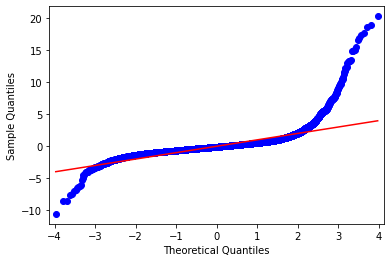

In [389]:
fig = sm.graphics.qqplot(ml_model7.resid, line='s',dist=stats.norm, fit=True)


# Homoscedasticity Check

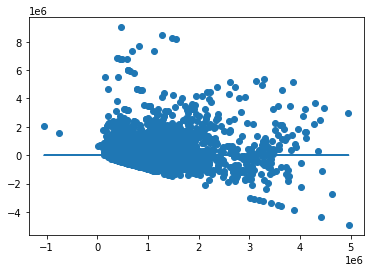

In [318]:
plt.scatter(ml_model7.predict(comb_df[x_cols]), ml_model7.resid)
plt.plot(ml_model7.predict(comb_df[x_cols]), [0 for i in range(len(comb_df))]);

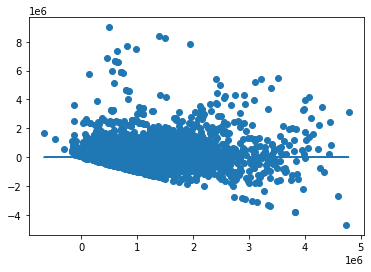

In [390]:
plt.scatter(ml_model7.predict(comb_df[x_cols]), ml_model7.resid)
plt.plot(ml_model7.predict(comb_df[x_cols]), [0 for i in range(len(comb_df))]);


# Model Improvements

### MI_Model1

In [392]:
#MI_Model1: remove not statistically significant inputs based on P-value> .05
#Removing: 'Duwamish', 'Lake_Union', 'River_or_slough', 'Has_OpenPorch', 'View_MtRainier', 'View_Cascades', 'NbrLivingUnits', 'Other_lake'
outcome = 'SalePrice'
x_cols = ['SqFtTotLiving', 'Lake_Sammamish', 
          'Lake_Washington','Puget_Sound', 'Ship_Canal',
         'TrafficNoise', 'PowerLines', 'Has_EnclosedPorch', 'ZipCode', 'View_Olympics', 
          'View_PugetSound', 'View_LakeWashington',
          'View_LakeSammamish','View_SmallLakeRiverCreek', 'SqFtLot', 'BldgGrade']


predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
mi_model1 = ols(formula=formula, data=comb_df).fit()
mi_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     1483.
Date:                Wed, 30 Sep 2020   Prob (F-statistic):               0.00
Time:                        10:51:37   Log-Likelihood:            -4.0116e+05
No. Observations:               27814   AIC:                         8.023e+05
Df Residuals:                   27797   BIC:                         8.025e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -2.078e+07    2.7e+06     -7.710      0.000   -2.61e+07   -1.55e+07
SqFtTotLiving              186.1396      4.102     45.377      0.000     178.099     194.180
Lake_Sammamish            1.497e+06   1.01e+05     14.843      0.000     1.3e+06    1.69e+06
Lake_Washington           1.237e+06   5.11e+04     24.210      0.000    1.14e+06    1.34e+06
Puget_Sound               2.088e+05   5.54e+04      3.770      0.000       1e+05    3.17e+05
Ship_Canal                6.121e+05   1.72e+05      3.568      0.000    2.76e+05    9.48e+05
TrafficNoise              1.999e+04   4801.882      4.162      0.000    1.06e+04    2.94e+04
PowerLines               -9.016e+04   2.61e+04     -3.450      0.001   -1.41e+05   -3.89e+04
Has_EnclosedPorch         7.659e+04   1.27e+04      6.022      0.000    5.17e+04    1.02e+05
ZipCode                    206.6323     27.481      7.519      0.000     152.769     260.496
View_Olympics             8.025e+04   9110.219      8.809      0.000    6.24e+04    9.81e+04
View_PugetSound            2.52e+04   1.01e+04      2.494      0.013    5394.536     4.5e+04
View_LakeWashington       2.053e+05   8513.279     24.117      0.000    1.89e+05    2.22e+05
View_LakeSammamish        6.796e+04    1.9e+04      3.581      0.000    3.08e+04    1.05e+05
View_SmallLakeRiverCreek  5.685e+04   1.02e+04      5.587      0.000    3.69e+04    7.68e+04
SqFtLot                     -0.3057      0.070     -4.371      0.000      -0.443      -0.169
BldgGrade                 1.533e+05   3238.736     47.321      0.000    1.47e+05     1.6e+05
==============================================================================
Omnibus:                    28386.611   Durbin-Watson:                   1.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4422342.231
Skew:                           4.731   Prob(JB):                         0.00
Kurtosis:                      64.044   Cond. No.                     1.01e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

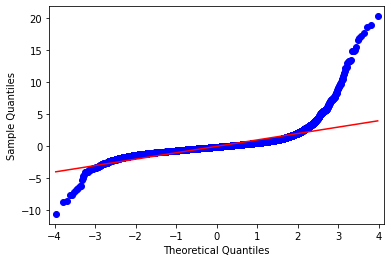

In [393]:
#QQ Plot
fig = sm.graphics.qqplot(mi_model1.resid, line='s',dist=stats.norm, fit=True)


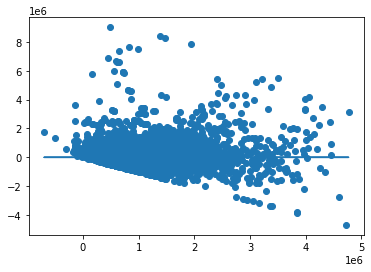

In [394]:
# Homoscedasticity Check
plt.scatter(mi_model1.predict(comb_df[x_cols]), mi_model1.resid)
plt.plot(mi_model1.predict(comb_df[x_cols]), [0 for i in range(len(comb_df))]);

In [395]:
# Multicolinearity Check
X = comb_df[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))


[('SqFtTotLiving', 13.795423845950202),
 ('Lake_Sammamish', 2.112658937147369),
 ('Lake_Washington', 1.5342113253108702),
 ('Puget_Sound', 1.3974218100240465),
 ('Ship_Canal', 1.043757394137219),
 ('TrafficNoise', 1.1477121585544507),
 ('PowerLines', 1.0207064978432971),
 ('Has_EnclosedPorch', 1.0626670077235234),
 ('ZipCode', 27.25113423888123),
 ('View_Olympics', 1.838004880803848),
 ('View_PugetSound', 2.3200564066700573),
 ('View_LakeWashington', 1.6212189497003393),
 ('View_LakeSammamish', 2.1380848684420783),
 ('View_SmallLakeRiverCreek', 1.0539680152705615),
 ('SqFtLot', 1.2041210707203522),
 ('BldgGrade', 51.46721806116019)]

In [396]:
#Rainbw VIF test
rainbow_statistic, rainbow_p_value = linear_rainbow(mi_model1)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 1.020369336976724
Rainbow p-value: 0.1172967762995222


In [ ]:
### MI_Model2

In [420]:
#MI_Model2: remove not statistically significant inputs based on P-value> .05
# taking Zip Code out because mutlicolinearity high, 'ZipCode'
outcome = 'SalePrice'
x_cols = ['SqFtTotLiving', 'Lake_Sammamish', 
          'Lake_Washington','Puget_Sound', 'Ship_Canal',
         'TrafficNoise', 'PowerLines', 'Has_EnclosedPorch', 'View_Olympics', 
          'View_PugetSound', 'View_LakeWashington',
          'View_LakeSammamish','View_SmallLakeRiverCreek', 'SqFtLot','BldgGrade' ]


predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
mi_model2 = ols(formula=formula, data=comb_df).fit()
mi_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                     1574.
Date:                Wed, 30 Sep 2020   Prob (F-statistic):               0.00
Time:                        11:02:21   Log-Likelihood:            -4.0118e+05
No. Observations:               27814   AIC:                         8.024e+05
Df Residuals:                   27798   BIC:                         8.025e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -5.134e+05   1.39e+04    -36.869      0.000   -5.41e+05   -4.86e+05
SqFtTotLiving              184.0391      4.097     44.924      0.000     176.009     192.069
Lake_Sammamish            1.503e+06   1.01e+05     14.884      0.000     1.3e+06     1.7e+06
Lake_Washington           1.231e+06   5.11e+04     24.074      0.000    1.13e+06    1.33e+06
Puget_Sound               1.988e+05   5.54e+04      3.588      0.000    9.02e+04    3.07e+05
Ship_Canal                6.247e+05   1.72e+05      3.638      0.000    2.88e+05    9.61e+05
TrafficNoise              2.136e+04   4803.224      4.446      0.000    1.19e+04    3.08e+04
PowerLines               -9.309e+04   2.62e+04     -3.559      0.000   -1.44e+05   -4.18e+04
Has_EnclosedPorch          8.07e+04   1.27e+04      6.345      0.000    5.58e+04    1.06e+05
View_Olympics             8.019e+04   9119.313      8.794      0.000    6.23e+04    9.81e+04
View_PugetSound           3.015e+04   1.01e+04      2.986      0.003    1.04e+04    4.99e+04
View_LakeWashington       2.072e+05   8518.087     24.324      0.000     1.9e+05    2.24e+05
View_LakeSammamish        6.527e+04    1.9e+04      3.436      0.001     2.8e+04    1.02e+05
View_SmallLakeRiverCreek   5.63e+04   1.02e+04      5.527      0.000    3.63e+04    7.63e+04
SqFtLot                     -0.3308      0.070     -4.730      0.000      -0.468      -0.194
BldgGrade                 1.531e+05   3241.897     47.224      0.000    1.47e+05    1.59e+05
==============================================================================
Omnibus:                    28301.033   Durbin-Watson:                   1.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4378853.552
Skew:                           4.708   Prob(JB):                         0.00
Kurtosis:                      63.743   Cond. No.                     2.70e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.7e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

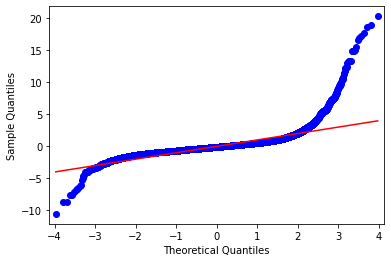

In [421]:
#QQ Plot
fig = sm.graphics.qqplot(mi_model2.resid, line='s',dist=stats.norm, fit=True)


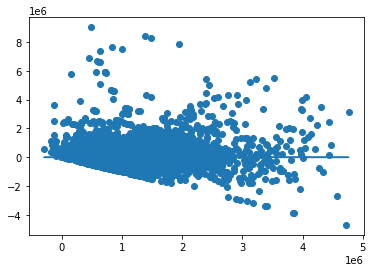

In [422]:
# Homoscedasticity Check
plt.scatter(mi_model2.predict(comb_df[x_cols]), mi_model2.resid)
plt.plot(mi_model2.predict(comb_df[x_cols]), [0 for i in range(len(comb_df))]);

In [423]:
# Multicolinearity Check
X = comb_df[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))


[('SqFtTotLiving', 12.262731140498255),
 ('Lake_Sammamish', 2.1117895831048417),
 ('Lake_Washington', 1.5319463846178147),
 ('Puget_Sound', 1.3967422488472332),
 ('Ship_Canal', 1.04375374431683),
 ('TrafficNoise', 1.1330798575300027),
 ('PowerLines', 1.020234684531163),
 ('Has_EnclosedPorch', 1.0598880316074137),
 ('View_Olympics', 1.8347945824023302),
 ('View_PugetSound', 2.319990307080393),
 ('View_LakeWashington', 1.6153218872348927),
 ('View_LakeSammamish', 2.1275649674749366),
 ('View_SmallLakeRiverCreek', 1.0536273017612536),
 ('SqFtLot', 1.2031109825375128),
 ('BldgGrade', 12.322310780392524)]

In [407]:
#looks like taking out the zip code helped the multicollinearity withSqFtTotLiving WITHOUT BuildingGrade

In [424]:
#Rainbw VIF test
rainbow_statistic, rainbow_p_value = linear_rainbow(mi_model2)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 1.0156234581002508
Rainbow p-value: 0.18040390072928963


In [426]:
#MI_Model3: remove not statistically significant inputs based on P-value> .05
# taking because mutlicolinearity high: ' 'SqFtTotLiving', 
#took out 'SqFtLot' because p value .09 in mi_model3
outcome = 'SalePrice'
x_cols = ['Lake_Sammamish', 
          'Lake_Washington','Puget_Sound', 'Ship_Canal',
         'TrafficNoise', 'PowerLines', 'Has_EnclosedPorch', 'View_Olympics', 
          'View_PugetSound', 'View_LakeWashington',
          'View_LakeSammamish','View_SmallLakeRiverCreek', 'BldgGrade' ]


predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
mi_model3 = ols(formula=formula, data=comb_df).fit()
mi_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     1549.
Date:                Wed, 30 Sep 2020   Prob (F-statistic):               0.00
Time:                        11:04:00   Log-Likelihood:            -4.0216e+05
No. Observations:               27814   AIC:                         8.043e+05
Df Residuals:                   27800   BIC:                         8.045e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -7.221e+05   1.36e+04    -53.116      0.000   -7.49e+05   -6.95e+05
Lake_Sammamish            1.507e+06   1.05e+05     14.410      0.000     1.3e+06    1.71e+06
Lake_Washington           1.184e+06    5.3e+04     22.353      0.000    1.08e+06    1.29e+06
Puget_Sound               1.536e+05   5.74e+04      2.678      0.007    4.12e+04    2.66e+05
Ship_Canal                5.575e+05   1.78e+05      3.135      0.002    2.09e+05    9.06e+05
TrafficNoise              1.291e+04   4970.388      2.598      0.009    3172.054    2.27e+04
PowerLines                -7.84e+04    2.7e+04     -2.907      0.004   -1.31e+05   -2.55e+04
Has_EnclosedPorch         3.207e+04   1.31e+04      2.443      0.015    6343.775    5.78e+04
View_Olympics             9.149e+04   9440.082      9.692      0.000     7.3e+04     1.1e+05
View_PugetSound           3.311e+04   1.05e+04      3.167      0.002    1.26e+04    5.36e+04
View_LakeWashington       2.301e+05   8803.482     26.137      0.000    2.13e+05    2.47e+05
View_LakeSammamish        7.794e+04   1.97e+04      3.963      0.000    3.94e+04    1.16e+05
View_SmallLakeRiverCreek  6.698e+04   1.05e+04      6.357      0.000    4.63e+04    8.76e+04
BldgGrade                  2.59e+05   2301.783    112.540      0.000    2.55e+05    2.64e+05
==============================================================================
Omnibus:                    27634.955   Durbin-Watson:                   1.073
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3528907.233
Skew:                           4.584   Prob(JB):                         0.00
Kurtosis:                      57.415   Cond. No.                         385.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

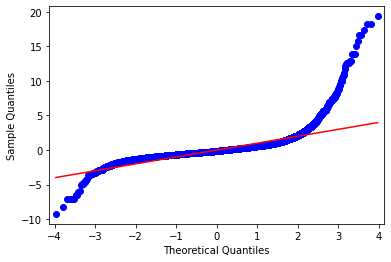

In [427]:
#QQ Plot
fig = sm.graphics.qqplot(mi_model3.resid, line='s',dist=stats.norm, fit=True)


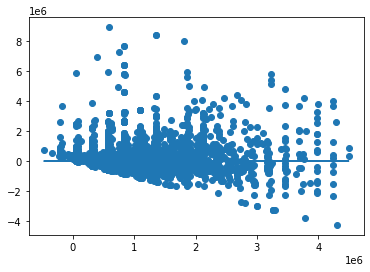

In [428]:
# Homoscedasticity Check
plt.scatter(mi_model3.predict(comb_df[x_cols]), mi_model3.resid)
plt.plot(mi_model3.predict(comb_df[x_cols]), [0 for i in range(len(comb_df))]);

In [429]:
# Multicolinearity Check
X = comb_df[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))


[('Lake_Sammamish', 2.1116982863701548),
 ('Lake_Washington', 1.5316550702816394),
 ('Puget_Sound', 1.3951970448578976),
 ('Ship_Canal', 1.0435096930483994),
 ('TrafficNoise', 1.1253206610966797),
 ('PowerLines', 1.0114157557053802),
 ('Has_EnclosedPorch', 1.0471128729272643),
 ('View_Olympics', 1.8308540271041862),
 ('View_PugetSound', 2.319804895242656),
 ('View_LakeWashington', 1.6026942856774433),
 ('View_LakeSammamish', 2.1240525862393533),
 ('View_SmallLakeRiverCreek', 1.0512392007449243),
 ('BldgGrade', 1.2430493665843552)]

In [430]:
#Rainbw VIF test
rainbow_statistic, rainbow_p_value = linear_rainbow(mi_model3)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 1.0148341355541872
Rainbow p-value: 0.19268915996403224
